### Facial Expression Comparison (in progress)  

Implementation of the paper: http://openaccess.thecvf.com/content_CVPR_2019/html/Vemulapalli_A_Compact_Embedding_for_Facial_Expression_Similarity_CVPR_2019_paper

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q "./drive/My Drive/Datasets/FEC_cropped/1"

In [0]:
!unzip -q "./drive/My Drive/Datasets/FEC_cropped/2"

In [0]:
!unzip -q "./drive/My Drive/Datasets/FEC_cropped/3"

In [5]:
!pip install tensorflow-gpu==2.0

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 450kB 43.1MB/s 
     |████████████████████████████████| 3.8MB 53.9MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import csv
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

print(tf.version.VERSION)

2.0.0


In [0]:
files_1 = os.listdir("./1")
files_2 = os.listdir("./2")
files_3 = os.listdir("./3")

In [0]:
names_1 = [int(name.split(".")[0]) for name in files_1]
names_1.sort()
names_2 = [int(name.split(".")[0]) for name in files_2]
names_2.sort()
names_3 = [int(name.split(".")[0]) for name in files_3]
names_3.sort()

In [9]:
print(names_1[-1], names_2[-1], names_3[-1])

449142 449142 449142


In [0]:
n = max(names_1[-1], names_2[-1], names_3[-1])
check_list1 = [False] * n
check_list2 = [False] * n
check_list3 = [False] * n
for x in names_1:
  check_list1[x-1] = True
for x in names_2:
  check_list2[x-1] = True
for x in names_3:
  check_list3[x-1] = True

In [0]:
check_list_all = [False] * n
for i in range(n):
  if check_list1[i] and check_list2[i] and check_list3[i]:
    check_list_all[i] = True

In [0]:
names_list = [(i+1) for i in range(n) if check_list_all[i]]

In [0]:
files_list = [(str(a) + ".jpg") for a in names_list]

In [14]:
print(len(files_list))

399967


In [0]:
with open('./files_list.txt', 'w') as f:
    for item in files_list:
        f.write("%s\n" % item)

In [0]:
FEC_SIZE = len(files_list)

In [0]:
files_list1 = [("./1/" + a) for a in files_list]
files_list2 = [("./2/" + a) for a in files_list]
files_list3 = [("./3/" + a) for a in files_list]

In [18]:
print(files_list1[0], files_list2[0], files_list3[0])

./1/1.jpg ./2/1.jpg ./3/1.jpg


In [0]:
list_ds1 = tf.data.Dataset.from_tensor_slices(files_list1)
list_ds2 = tf.data.Dataset.from_tensor_slices(files_list2)
list_ds3 = tf.data.Dataset.from_tensor_slices(files_list3)

In [0]:
triplets_list_ds = tf.data.Dataset.zip((list_ds1, list_ds2, list_ds3))

In [0]:
triplets_list_ds = triplets_list_ds.shuffle(500000)

In [0]:
TRAIN_SIZE = 320000
VALIDATION_SIZE = FEC_SIZE - TRAIN_SIZE

In [0]:
train_files_ds = triplets_list_ds.take(TRAIN_SIZE)
valid_files_ds = triplets_list_ds.skip(TRAIN_SIZE)

In [24]:
for f in list_ds2.take(5):
  print(tf.strings.to_number(tf.strings.split(tf.strings.split(f, sep="/")[-1], sep=".")[0], out_type=tf.int32))

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)


In [25]:
for a, b, c in valid_files_ds.take(5):
  print(a.numpy(), b.numpy(), c.numpy())

b'./1/346905.jpg' b'./2/346905.jpg' b'./3/346905.jpg'
b'./1/115413.jpg' b'./2/115413.jpg' b'./3/115413.jpg'
b'./1/31914.jpg' b'./2/31914.jpg' b'./3/31914.jpg'
b'./1/422085.jpg' b'./2/422085.jpg' b'./3/422085.jpg'
b'./1/259737.jpg' b'./2/259737.jpg' b'./3/259737.jpg'


In [0]:
data = pd.read_csv("./drive/My Drive/Datasets/FEC/train.csv")

In [27]:
data.head()

,link1,x_min1,x_max1,y_min1,y_max1,link2,x_min2,x_max2,y_min2,y_max2,link3,x_min3,x_max3,y_min3,y_max3,class_type,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38
0,http://farm5.staticflickr.com/4108/5185055338_...,0.142578,0.266602,0.065421,0.297508,http://farm4.staticflickr.com/3543/3387356856_...,0.335938,0.441406,0.130307,0.311859,http://farm4.staticflickr.com/3674/9280612097_...,0.359307,0.562771,0.514648,0.673828,TWO_CLASS_TRIPLET,291701,3,321402,2,321601,3,4295017797,2,4295017896,2,48316,2,NaN,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,http://farm4.staticflickr.com/3338/3571087393_...,0.645508,0.710938,0.053571,0.517857,http://farm3.staticflickr.com/2915/14407773031...,0.363281,0.482422,0.076125,0.321799,http://farm4.staticflickr.com/3674/9280612097_...,0.359307,0.562771,0.514648,0.673828,ONE_CLASS_TRIPLET,147101,3,291301,3,300701,2,321501,2,4294978797,2,4294989896,3,NaN,29963,14,1,2,NaN,NaN,NaN,NaN,NaN,NaN
2,http://farm6.staticflickr.com/5087/5289788172_...,0.206055,0.290039,0.217610,0.343396,http://farm3.staticflickr.com/2771/4359780393_...,0.000000,0.123047,0.201471,0.472059,http://farm4.staticflickr.com/3674/9280612097_...,0.359307,0.562771,0.514648,0.673828,ONE_CLASS_TRIPLET,269701,3,300901,3,321601,3,321902,3,322102,3,41207,3,NaN,57264,25,1,3,NaN,NaN,NaN,NaN,NaN,NaN
3,http://farm8.staticflickr.com/7001/13409767313...,0.028320,0.112305,0.474692,0.611491,http://farm8.staticflickr.com/7435/10257752223...,0.537949,0.696405,0.060547,0.195312,http://farm4.staticflickr.com/3674/9280612097_...,0.359307,0.562771,0.514648,0.673828,THREE_CLASS_TRIPLET,291701,1,321601,3,321902,2,322102,2,4294978797,3,48316,1,NaN,25051,39,1,4,NaN,NaN,NaN,NaN,NaN,NaN
4,http://farm6.staticflickr.com/5555/14220355443...,0.101562,0.318359,0.156662,0.532943,http://farm4.staticflickr.com/3903/15033634365...,0.352539,0.468750,0.351391,0.553441,http://farm4.staticflickr.com/3674/9280612097_...,0.359307,0.562771,0.514648,0.673828,THREE_CLASS_TRIPLET,147101,2,221901,2,269701,1,321501,2,41207,2,48316,2,NaN,15297,187,1,5,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
data[data['col33'] == 5].values.tolist()[0][21]

1

In [0]:
classes = []
for cl in data['class_type'].values.tolist():
  if cl == 'ONE_CLASS_TRIPLET':
    classes.append(1)
  elif cl == 'TWO_CLASS_TRIPLET':
    classes.append(2)
  elif cl == 'THREE_CLASS_TRIPLET':
    classes.append(3)

In [0]:
class_type = tf.convert_to_tensor(classes, dtype=tf.float32)

In [0]:
col33 = tf.convert_to_tensor(data['col33'].values.tolist())
labels = tf.convert_to_tensor(list(zip(data['col18'].values.tolist(),data['col20'].values.tolist(),data['col22'].values.tolist(),data['col24'].values.tolist(),data['col26'].values.tolist(),data['col28'].values.tolist())))

In [0]:
def get_label(file_paths):
  a, b, c = file_paths
  index = tf.strings.to_number(tf.strings.split(tf.strings.split(a, sep="/")[-1], sep=".")[0], out_type=tf.int32)
  row = labels[col33 == index][0]
  ones = tf.cast(tf.equal(row, 1), tf.int8) * 1
  twos = tf.cast(tf.equal(row, 2), tf.int8) * 1
  threes = tf.cast(tf.equal(row, 3), tf.int8) * 1
  cl = class_type[index-1]
  label = tf.stack([tf.reduce_sum(ones)/6, tf.reduce_sum(twos)/6, tf.reduce_sum(threes)/6, cl], 0)
  return label

In [33]:
for f in train_files_ds.take(5):
  print(get_label(f))

tf.Tensor([0.16666667 0.6666667  0.16666667 2.        ], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 0. 3.], shape=(4,), dtype=float32)
tf.Tensor([0.33333334 0.5        0.16666667 3.        ], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 1. 3.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 1. 1.], shape=(4,), dtype=float32)


In [0]:
IMG_WIDTH = 96
IMG_HEIGHT = 96
BATCH_SIZE = 128

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
def process_path(a, b, c):
  label = tf.map_fn(get_label, (a,b,c), parallel_iterations=32, dtype=tf.float32)
  # load the raw data from the file as a string
  img1 = tf.map_fn(tf.io.read_file, a, parallel_iterations=32)
  img2 = tf.map_fn(tf.io.read_file, b, parallel_iterations=32)
  img3 = tf.map_fn(tf.io.read_file, c, parallel_iterations=32)
  img1 = tf.map_fn(decode_img, img1, parallel_iterations=32, dtype=tf.float32)
  img2 = tf.map_fn(decode_img, img2, parallel_iterations=32, dtype=tf.float32)
  img3 = tf.map_fn(decode_img, img3, parallel_iterations=32, dtype=tf.float32)
  imgs = tf.transpose(tf.convert_to_tensor([img1, img2, img3]), perm=[1, 0, 2, 3, 4])
  return imgs, label

In [0]:
train_files_batched_ds = train_files_ds.batch(BATCH_SIZE)
valid_files_batched_ds = valid_files_ds.batch(BATCH_SIZE)

In [0]:
train_images_batched_ds = train_files_batched_ds.interleave(lambda a,b,c: tf.data.Dataset.from_tensors(process_path(a,b,c)) , cycle_length=6, block_length=1, num_parallel_calls=AUTOTUNE)
valid_images_batched_ds = valid_files_batched_ds.interleave(lambda a,b,c: tf.data.Dataset.from_tensors(process_path(a,b,c)) , cycle_length=6, block_length=1, num_parallel_calls=AUTOTUNE)

In [0]:
# train_images_ds = train_files_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# valid_images_ds = valid_files_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [0]:
# train_images_batched_ds = train_files_batched_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# valid_images_batched_ds = valid_files_batched_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [40]:
i = 1
for image, label in train_images_batched_ds.take(5):
  print("Triplet: ", i)
  print("Triplet shape: ", image.shape)
  print("Label shape: ", label.shape)
  print(" ")
  i += 1

Triplet:  1
Triplet shape:  (128, 3, 96, 96, 3)
Label shape:  (128, 4)
 
Triplet:  2
Triplet shape:  (128, 3, 96, 96, 3)
Label shape:  (128, 4)
 
Triplet:  3
Triplet shape:  (128, 3, 96, 96, 3)
Label shape:  (128, 4)
 
Triplet:  4
Triplet shape:  (128, 3, 96, 96, 3)
Label shape:  (128, 4)
 
Triplet:  5
Triplet shape:  (128, 3, 96, 96, 3)
Label shape:  (128, 4)
 


In [0]:
def prepare_for_training(ds, cache="./fec.tfcache"):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
    
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  # Repeat forever
  ds = ds.repeat()

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(train_images_batched_ds, cache=False)

valid_ds = prepare_for_training(valid_images_batched_ds, cache=False)


In [0]:
def show(image):
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

[0.166666672 0.333333343 0.5 3]


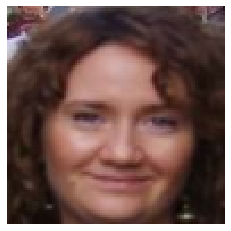

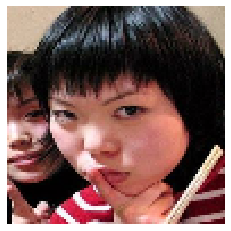

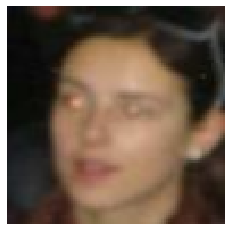

In [44]:
for imgs, labels in valid_ds.take(1):
  a, b, c = imgs[5]
  tf.print(labels[5])
  show(a)
  show(b)
  show(c)

In [0]:
# for imgs, labels in train_ds.take(int(TRAIN_SIZE / BATCH_SIZE)):
#   pass

In [0]:
# for imgs, labels in valid_ds.take(int(VALIDATION_SIZE / BATCH_SIZE)):
#   pass

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.layers import Layer
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow.keras as K

def LRN2D(x):
  return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(
  x,
  layer=None,
  cv1_out=None,
  cv1_filter=(1, 1),
  cv1_strides=(1, 1),
  cv2_out=None,
  cv2_filter=(3, 3),
  cv2_strides=(1, 1),
  padding=None,
):
  num = '' if cv2_out == None else '1'
  tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, name=layer+'_conv'+num)(x)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
  tensor = Activation('relu')(tensor)
  if padding == None:
    return tensor
  tensor = ZeroPadding2D(padding=padding)(tensor)
  if cv2_out == None:
    return tensor
  tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, name=layer+'_conv'+'2')(tensor)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
  tensor = Activation('relu')(tensor)
  return tensor

def facenet():
    myInput = Input(shape=(96, 96, 3))

    x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
    x = Activation('relu')(x)
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Inception3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    # Inception3b
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = Lambda(lambda x: x**2, name='power2_3b')(inception_3a)
    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3b_pool)
    inception_3b_pool = Lambda(lambda x: x*9, name='mult9_3b')(inception_3b_pool)
    inception_3b_pool = Lambda(lambda x: tf.math.sqrt(x), name='sqrt_3b')(inception_3b_pool)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    # Inception3c
    inception_3c_3x3 = conv2d_bn(inception_3b,
                                    layer='inception_3c_3x3',
                                    cv1_out=128,
                                    cv1_filter=(1, 1),
                                    cv2_out=256,
                                    cv2_filter=(3, 3),
                                    cv2_strides=(2, 2),
                                    padding=(1, 1))

    inception_3c_5x5 = conv2d_bn(inception_3b,
                                    layer='inception_3c_5x5',
                                    cv1_out=32,
                                    cv1_filter=(1, 1),
                                    cv2_out=64,
                                    cv2_filter=(5, 5),
                                    cv2_strides=(2, 2),
                                    padding=(2, 2))

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    #inception 4a
    inception_4a_3x3 = conv2d_bn(inception_3c,
                                    layer='inception_4a_3x3',
                                    cv1_out=96,
                                    cv1_filter=(1, 1),
                                    cv2_out=192,
                                    cv2_filter=(3, 3),
                                    cv2_strides=(1, 1),
                                    padding=(1, 1))
    inception_4a_5x5 = conv2d_bn(inception_3c,
                                    layer='inception_4a_5x5',
                                    cv1_out=32,
                                    cv1_filter=(1, 1),
                                    cv2_out=64,
                                    cv2_filter=(5, 5),
                                    cv2_strides=(1, 1),
                                    padding=(2, 2))

    inception_4a_pool = Lambda(lambda x: x**2, name='power2_4a')(inception_3c)
    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4a_pool)
    inception_4a_pool = Lambda(lambda x: x*9, name='mult9_4a')(inception_4a_pool)
    inception_4a_pool = Lambda(lambda x: tf.math.sqrt(x), name='sqrt_4a')(inception_4a_pool)
    inception_4a_pool = conv2d_bn(inception_4a_pool,
                                    layer='inception_4a_pool',
                                    cv1_out=128,
                                    cv1_filter=(1, 1),
                                    padding=(2, 2))
    inception_4a_1x1 = conv2d_bn(inception_3c,
                                    layer='inception_4a_1x1',
                                    cv1_out=256,
                                    cv1_filter=(1, 1))
    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    #inception4e
    inception_4e_3x3 = conv2d_bn(inception_4a,
                                    layer='inception_4e_3x3',
                                    cv1_out=160,
                                    cv1_filter=(1, 1),
                                    cv2_out=256,
                                    cv2_filter=(3, 3),
                                    cv2_strides=(2, 2),
                                    padding=(1, 1))
    inception_4e_5x5 = conv2d_bn(inception_4a,
                                    layer='inception_4e_5x5',
                                    cv1_out=64,
                                    cv1_filter=(1, 1),
                                    cv2_out=128,
                                    cv2_filter=(5, 5),
                                    cv2_strides=(2, 2),
                                    padding=(2, 2))
    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    #inception5a
    inception_5a_3x3 = conv2d_bn(inception_4e,
                                    layer='inception_5a_3x3',
                                    cv1_out=96,
                                    cv1_filter=(1, 1),
                                    cv2_out=384,
                                    cv2_filter=(3, 3),
                                    cv2_strides=(1, 1),
                                    padding=(1, 1))

    inception_5a_pool = Lambda(lambda x: x**2, name='power2_5a')(inception_4e)
    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_5a_pool)
    inception_5a_pool = Lambda(lambda x: x*9, name='mult9_5a')(inception_5a_pool)
    inception_5a_pool = Lambda(lambda x: tf.math.sqrt(x), name='sqrt_5a')(inception_5a_pool)
    inception_5a_pool = conv2d_bn(inception_5a_pool,
                                    layer='inception_5a_pool',
                                    cv1_out=96,
                                    cv1_filter=(1, 1),
                                    padding=(1, 1))
    inception_5a_1x1 = conv2d_bn(inception_4e,
                                    layer='inception_5a_1x1',
                                    cv1_out=256,
                                    cv1_filter=(1, 1))

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    #inception_5b
    inception_5b_3x3 = conv2d_bn(inception_5a,
                                    layer='inception_5b_3x3',
                                    cv1_out=96,
                                    cv1_filter=(1, 1),
                                    cv2_out=384,
                                    cv2_filter=(3, 3),
                                    cv2_strides=(1, 1),
                                    padding=(1, 1))
    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = conv2d_bn(inception_5b_pool,
                                    layer='inception_5b_pool',
                                    cv1_out=96,
                                    cv1_filter=(1, 1))
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = conv2d_bn(inception_5a,
                                    layer='inception_5b_1x1',
                                    cv1_out=256,
                                    cv1_filter=(1, 1))
    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(128, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda  x: tf.math.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    # Final Model
    model = Model(inputs=[myInput], outputs=norm_layer)
    return model

In [0]:
# faceNet = tf.keras.models.load_model('./drive/My Drive/Models/keras-facenet/model/facenet_keras.h5')
# faceNet.summary()

In [0]:
nn4 = facenet()

In [50]:
nn4.load_weights('./drive/My Drive/Models/nn4.small2.v1.h5')
nn4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [0]:
for layer in nn4.layers:
  layer.trainable = False

In [0]:
# tf.keras.utils.plot_model(faceNet)

In [53]:
base_model = keras.models.Model(inputs=nn4.input, outputs=nn4.get_layer(name="concatenate_4").output)
base_model.trainable = False
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
def conv_block(x, growth_rate, name):
  """A building block for a dense block.
  # Arguments
      x: input tensor.
      growth_rate: float, growth rate at dense layers.
      name: string, block label.
  # Returns
      Output tensor for the block.
  """
  x1 = layers.BatchNormalization(epsilon=1.001e-5,
                                  name=name + '_0_bn')(x)
  x1 = layers.ReLU(max_value=6., name=name + '_0_relu')(x1)
  x1 = layers.Dropout(0.4)(x1)
  x1 = layers.Conv2D(4 * growth_rate, 1,
                      use_bias=False,
                      name=name + '_1_conv')(x1)
  x1 = layers.BatchNormalization(epsilon=1.001e-5,
                                  name=name + '_1_bn')(x1)
  x1 = layers.ReLU(max_value=6., name=name + '_1_relu')(x1)
  x1 = layers.Dropout(0.4)(x1)
  x1 = layers.Conv2D(growth_rate, 3,
                      padding='same',
                      use_bias=False,
                      name=name + '_2_conv')(x1)
  x = layers.Concatenate(name=name + '_concat')([x, x1])
  return x

def dense_block(x, blocks, name, growth=64):
  """A dense block.
  # Arguments
      x: input tensor.
      blocks: integer, the number of building blocks.
      name: string, block label.
  # Returns
      output tensor for the block.
  """
  for i in range(blocks):
      x = conv_block(x, growth, name=name + '_block' + str(i + 1))
  return x

In [0]:
def get_embeddings(input_tensor):
  x = base_model(input_tensor)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Conv2D(512, 1, padding='same', use_bias=False)(x)
  x = dense_block(x, 5, name="dense1")
  x = keras.layers.BatchNormalization(epsilon=1.001e-5)(x)
  x = keras.layers.ReLU(max_value=6.)(x)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)
  x = keras.layers.Dense(512)(x)
  x = keras.layers.BatchNormalization(epsilon=1.001e-5)(x)
  x = keras.layers.ReLU(max_value=6.)(x)
  x = layers.Dropout(0.5)(x)
  x = keras.layers.Dense(16)(x)
  x = tf.math.l2_normalize(x, axis=-1)
  return x

In [0]:
inputs = keras.layers.Input(shape=(96, 96, 3))
x = get_embeddings(inputs)
feature_extractor = keras.Model(inputs, x, name="FEC_extractor")

In [57]:
feature_extractor.summary()

Model: "FEC_extractor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 3, 3, 1024)   2188592     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 3, 3, 1024)   0           model_1[1][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 3, 512)    524288      dropout[0][0]                    
______________________________________________________________________________________

In [58]:
inputs = keras.layers.Input(shape=(3,96, 96, 3))

I1 = inputs[:,0,:,:,:]
I2 = inputs[:,1,:,:,:]
I3 = inputs[:,2,:,:,:]



e_I1 = tf.expand_dims(feature_extractor(I1), axis=1)
e_I2 = tf.expand_dims(feature_extractor(I2), axis=1)
e_I3 = tf.expand_dims(feature_extractor(I3), axis=1)

outs = tf.concat([e_I1, e_I2, e_I3], axis=1)

model = keras.models.Model(inputs=inputs, outputs=outs, name="FECNet")
model.summary()

Model: "FECNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3, 96, 96, 3 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 96, 96, 3)]  0           input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 96, 96, 3)]  0           input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 96, 96, 3)]  0           input_3[0][0]                    
_____________________________________________________________________________________________

In [0]:
# tf.keras.utils.plot_model(model)

In [0]:
class FECLoss(keras.losses.Loss):
  def __init__(
      self,
      reduction=keras.losses.Reduction.AUTO,
      name='loss',
      margin=0.1,
  ):
    super(FECLoss, self).__init__()
    self.margin = margin

  def call(self, labels, embeddings):
    
    ## embeddings shape is (BATCH_SIZE, 3, EMBEDDING_SIZE)
    e_I1 = embeddings[:, 0, :]
    e_I2 = embeddings[:, 1, :]
    e_I3 = embeddings[:, 2, :]
    
    ## I1 & I2 are the most simmiliar pair
    d_pos = tf.reduce_sum(tf.square(e_I1 - e_I2), axis=-1)
    d_neg1 = tf.reduce_sum(tf.square(e_I1 - e_I3), axis=-1)
    d_neg2 = tf.reduce_sum(tf.square(e_I2 - e_I3), axis=-1)
    
    loss3 = tf.maximum(0., d_pos - d_neg1 + self.margin) + tf.maximum(0., d_pos - d_neg2 + self.margin)

    ## I2 & I3 are the most simmiliar pair
    d_pos = tf.reduce_sum(tf.square(e_I2 - e_I3), axis=-1)
    d_neg1 = tf.reduce_sum(tf.square(e_I1 - e_I3), axis=-1)
    d_neg2 = tf.reduce_sum(tf.square(e_I2 - e_I1), axis=-1)
    
    loss1 = tf.maximum(0., d_pos - d_neg1 + self.margin) + tf.maximum(0., d_pos - d_neg2 + self.margin)

    ## I1 & I3 are the most simmiliar pair
    d_pos = tf.reduce_sum(tf.square(e_I1 - e_I3), axis=-1)
    d_neg1 = tf.reduce_sum(tf.square(e_I1 - e_I2), axis=-1)
    d_neg2 = tf.reduce_sum(tf.square(e_I2 - e_I3), axis=-1)
    
    loss2 = tf.maximum(0., d_pos - d_neg1 + self.margin) + tf.maximum(0., d_pos - d_neg2 + self.margin)

    weights = tf.cast(labels[:,0:3], tf.float32)

    loss1 = tf.expand_dims(loss1,-1)
    loss2 = tf.expand_dims(loss2,-1)
    loss3 = tf.expand_dims(loss3,-1)

    loss = tf.reduce_sum(tf.concat([loss1,loss2,loss3], -1) * weights, axis=-1)
    
    return loss

In [0]:
class FECMetrics(keras.metrics.Metric):

    def __init__(self, name='accuracy', **kwargs):
      super(FECMetrics, self).__init__(name=name, **kwargs)
      self.accuracy = keras.metrics.Accuracy()

    def update_state(self, y_true, y_pred, sample_weight=None):

      e_I1 = y_pred[:, 0, :]
      e_I2 = y_pred[:, 1, :]
      e_I3 = y_pred[:, 2, :]

      labels = tf.reshape(y_true[:, 0:3], (-1, 3))

      d12 = tf.expand_dims(tf.reduce_sum(tf.square(e_I1 - e_I2), axis=-1), axis=-1)
      d13 = tf.expand_dims(tf.reduce_sum(tf.square(e_I1 - e_I3), axis=-1), axis=-1)
      d23 = tf.expand_dims(tf.reduce_sum(tf.square(e_I3 - e_I2), axis=-1), axis=-1)

      distances = tf.concat([d23, d13, d12], axis=-1)

      min_indices = tf.argmin(distances, axis=-1)
      true_labels = tf.argmax(labels, axis=-1)

      self.accuracy.update_state(min_indices, true_labels)


    def result(self):
      return self.accuracy.result()
      
    def reset_states(self):
      self.accuracy.reset_states()


In [0]:
# model = keras.models.load_model("./drive/My Drive/Models/FEC/fecnet_nn4_2", compile=False)

In [0]:
num_train = TRAIN_SIZE
num_valid = VALIDATION_SIZE
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = round(num_valid)//BATCH_SIZE

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=FECLoss(margin=0.15), metrics=[FECMetrics()])

In [63]:
model.evaluate(valid_ds, steps=10)

10/10 [==============================] - 35s 4s/step - loss: 0.2940 - accuracy: 0.3516


[0.2939596712589264, 0.3515625]

In [0]:
latest = tf.train.latest_checkpoint('./drive/My Drive/Models/FEC/')
model.load_weights(latest)

In [76]:
model.evaluate(valid_ds, steps=validation_steps)

624/624 [==============================] - 535s 857ms/step - loss: 0.2514 - accuracy: 0.4882


[0.25139215493049377, 0.48818108]

In [0]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='./drive/My Drive/Models/FEC/Checkpoints/fecnet_nn4_{epoch}_{val_accuracy:.2f}',
        save_weights_only=True,
        save_best_only=True,
        monitor='loss',
        verbose=1),
    keras.callbacks.EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
]

history = model.fit(train_ds,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    initial_epoch=2,
                    epochs=100,
                    validation_data=valid_ds,
                    validation_steps=validation_steps)

model.save("./drive/My Drive/Models/FEC/fecnet_nn4")

Train for 2500 steps, validate for 624 steps
Epoch 3/100
 372/2500 [===>..........................] - ETA: 32:00 - loss: 0.2576 - accuracy: 0.4615

In [0]:
model.evaluate(valid_ds)